# 04 — Neighborhood Analysis

Geographic segmentation of the Austin STR market. Different neighborhoods command
different price points, attract different guests, and have varying levels of saturation.

**Key Questions:**
- Which neighborhoods have the highest ADR?
- Where is supply concentrated?
- Which areas show signs of saturation vs. opportunity?

## Setup

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import load_listings, load_geojson, load_config
from src.data_cleaner import clean_listings
from src.analyzers.neighborhood import NeighborhoodAnalyzer
from src.visualizations.charts import ChartGenerator

config = load_config()
charts = ChartGenerator()

%matplotlib inline

## Data Loading

In [2]:
listings = clean_listings(load_listings('../data/sample/listings_sample.csv'))
geo = load_geojson('../data/sample/neighbourhoods.geojson')

analyzer = NeighborhoodAnalyzer(listings, geo, config)

print(f'Active listings: {len(listings):,}')
print(f'Neighborhoods in data: {listings.neighbourhood_cleansed.nunique()}')
print(f'Neighborhoods in GeoJSON: {len(geo)}')

Active listings: 215
Neighborhoods in data: 33
Neighborhoods in GeoJSON: 44


## ADR by Neighborhood

Only neighborhoods with 3+ listings are included to ensure statistical relevance.

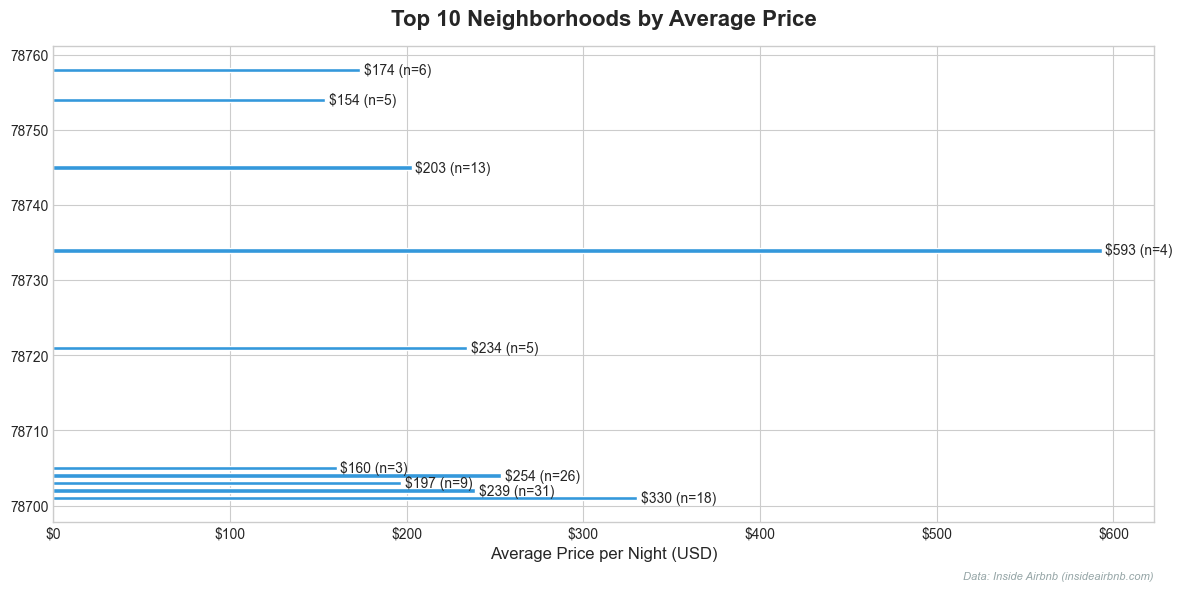

In [3]:
adr_nh = analyzer.get_adr_by_neighborhood(min_listings=3)
display(adr_nh.style.format({
    'adr_mean': '${:,.0f}', 'adr_median': '${:,.0f}', 'adr_std': '${:,.0f}'
}))

charts.plot_adr_by_neighborhood(listings, top_n=10, save_as='adr_by_neighborhood')
plt.show()

## Listing Density

In [4]:
density = analyzer.get_listing_density()
display(density.head(15).style.format({'pct_of_total': '{:.1f}%'}))

charts.plot_listing_density(listings, top_n=15, save_as='listing_density')
plt.show()

/Users/alvaroquintasmartinsfaustino/Projects/airbnb/airbnb-business/airbnb-market-analyzer/src/visualizations/charts.py:380: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


## Price Heatmap

Choropleth map showing average nightly price by neighborhood.

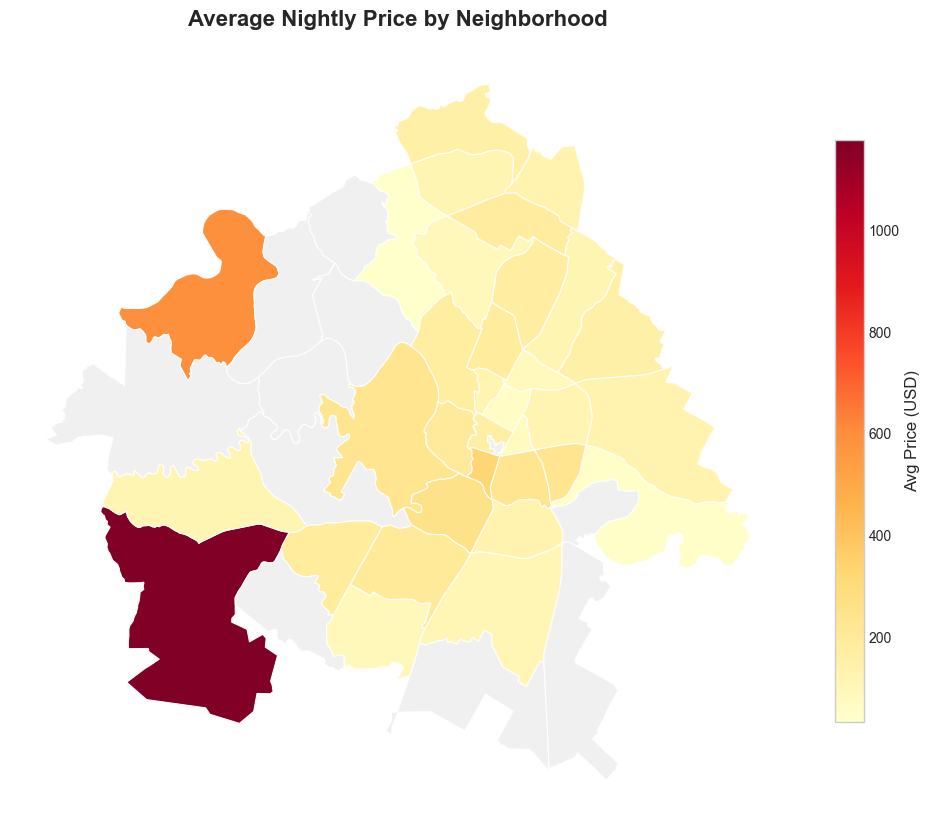

In [5]:
heatmap_data = analyzer.get_price_heatmap_data()

charts.plot_price_heatmap(heatmap_data, save_as='neighborhood_price_heatmap')
plt.show()

## Market Saturation Score

A composite score (0–1) combining supply density and booking demand.
Higher scores indicate more saturated markets; lower scores may represent opportunities.

In [6]:
saturation = analyzer.get_market_saturation_score()

fig, ax = plt.subplots(figsize=(12, 6))
top_sat = saturation.head(10).sort_values('saturation_score')
colors = plt.cm.RdYlGn_r(top_sat['saturation_score'])
ax.barh(top_sat.index, top_sat['saturation_score'], color=colors, edgecolor='white', height=0.6)
ax.set_title('Top 10 Most Saturated Neighborhoods', fontweight='bold', fontsize=14)
ax.set_xlabel('Saturation Score (0=Low, 1=High)')
ax.set_xlim(0, 1)

for i, (nh, row) in enumerate(top_sat.iterrows()):
    ax.text(row['saturation_score'] + 0.02, i, f"{row['saturation_score']:.2f}",
            va='center', fontsize=10)

plt.tight_layout()
plt.show()

/var/folders/tg/30x40kdj5rb5l8_f70yysh_r0000gn/T/ipykernel_45808/3314324837.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


## Neighborhood Deep Dive

In [7]:
# Profile the top 3 neighborhoods by listing count
top_neighborhoods = listings['neighbourhood_cleansed'].value_counts().head(3).index.tolist()

for nh in top_neighborhoods:
    profile = analyzer.get_neighborhood_profile(nh)
    print(f"\n{'─' * 40}")
    print(f"  {profile['neighborhood']}")
    print(f"{'─' * 40}")
    print(f"  Listings:       {profile['total_listings']}")
    print(f"  ADR (mean):     ${profile['adr_mean']:,.0f}")
    print(f"  ADR (median):   ${profile['adr_median']:,.0f}")
    print(f"  Avg rating:     {profile['avg_rating']:.2f}")
    print(f"  Dominant type:  {profile['dominant_room_type']}")
    if profile.get('pct_superhost'):
        print(f"  Superhosts:     {profile['pct_superhost']:.0f}%")


────────────────────────────────────────
  78702
────────────────────────────────────────
  Listings:       31
  ADR (mean):     $239
  ADR (median):   $149
  Avg rating:     4.92
  Dominant type:  Entire home/apt
  Superhosts:     79%

────────────────────────────────────────
  78704
────────────────────────────────────────
  Listings:       26
  ADR (mean):     $254
  ADR (median):   $168
  Avg rating:     4.91
  Dominant type:  Entire home/apt
  Superhosts:     85%

────────────────────────────────────────
  78701
────────────────────────────────────────
  Listings:       18
  ADR (mean):     $330
  ADR (median):   $250
  Avg rating:     4.69
  Dominant type:  Entire home/apt
  Superhosts:     44%


## Key Findings

1. **Central neighborhoods (78701, 78704) command premium prices** — proximity to downtown, entertainment, and dining drives ADR
2. **Supply concentrates in popular areas** — the top 5 neighborhoods hold the majority of listings
3. **Suburban neighborhoods show lower saturation** — potential opportunity for differentiated offerings
4. **Price heatmap reveals a clear gradient** from expensive central areas to more affordable suburbs
5. **Saturation varies significantly** — some neighborhoods are competitive while others have room for new supply

**Recommendation:** New investors should consider neighborhoods with moderate demand but low saturation scores — these offer the best entry points.

**Next:** [05 — Competitive Landscape](05_competitive_landscape.ipynb) for positioning analysis.